# Import dependencies

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import random
import matplotlib.pyplot as plt
import math
import regex
import time
from datasets import Dataset
import pickle
from torch.utils.data.dataset import Dataset as torch_Dataset
%run './utils_gpt.ipynb'

# Device setting

In [2]:
device = torch.device("mps:0") if torch.backends.mps.is_available() else torch.device("cpu")
# In macos, using mps:0
# In windows,using cuda
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.backends.mps.is_available():
    device = torch.device("mps:0") # for MacBook
elif torch.cuda.is_available():
    device = 'cuda'
else :
    device = 'cpu'
print(device)

mps:0


# Data preparation

In [3]:
bpe_re = BytePairEncoding()

with open('./vocabulary/bpe_vocab.pkl', 'rb') as f:
    bpe_re.vocab = pickle.load(f)

with open('./vocabulary/bpe_merges.pkl', 'rb') as f:
    bpe_re.merges = pickle.load(f)


In [27]:
train_data_bpere = ShakespeareDataset(mode='train',bpe_re=bpe_re)
val_data_bpere = ShakespeareDataset( mode='val',bpe_re=bpe_re)


--2024-04-17 10:15:11--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt.2”

input.txt.2         100%[===================>]   1.06M  --.-KB/s  用时 0.1s      

2024-04-17 10:15:12 (8.83 MB/s) - 已保存 “input.txt.2” [1115394/1115394])



Map (num_proc=8):   0%|          | 0/31497 [00:00<?, ? examples/s]

--2024-04-17 10:15:17--  https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
正在解析主机 raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
正在连接 raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... 已连接。
已发出 HTTP 请求，正在等待回应... 200 OK
长度：1115394 (1.1M) [text/plain]
正在保存至: “input.txt.3”

input.txt.3         100%[===================>]   1.06M  --.-KB/s  用时 0.1s      

2024-04-17 10:15:17 (9.86 MB/s) - 已保存 “input.txt.3” [1115394/1115394])



Map (num_proc=8):   0%|          | 0/4030 [00:00<?, ? examples/s]

## Baseline model

5.881913 M parameters
step 0: train loss 8.2529, val loss 8.2562
step 100: train loss 6.9681, val loss 7.0926
step 200: train loss 6.6319, val loss 6.8075
step 300: train loss 6.2425, val loss 6.3446
step 400: train loss 5.9117, val loss 6.0296
step 500: train loss 5.6515, val loss 5.8486
step 600: train loss 5.4771, val loss 5.6473
step 700: train loss 5.3280, val loss 5.5695
step 800: train loss 5.2082, val loss 5.5135
step 900: train loss 5.1627, val loss 5.4541
step 1000: train loss 5.0534, val loss 5.3966
step 1100: train loss 5.0184, val loss 5.3721
step 1200: train loss 4.9755, val loss 5.3571
step 1300: train loss 4.9130, val loss 5.3222
step 1400: train loss 4.8638, val loss 5.2778
step 1500: train loss 4.8094, val loss 5.2820
step 1600: train loss 4.7920, val loss 5.2637
step 1700: train loss 4.7527, val loss 5.1761
step 1800: train loss 4.7373, val loss 5.2141
step 1900: train loss 4.7103, val loss 5.1983
step 2000: train loss 4.6840, val loss 5.1780
step 2100: train loss 4.

NameError: name 'bs' is not defined

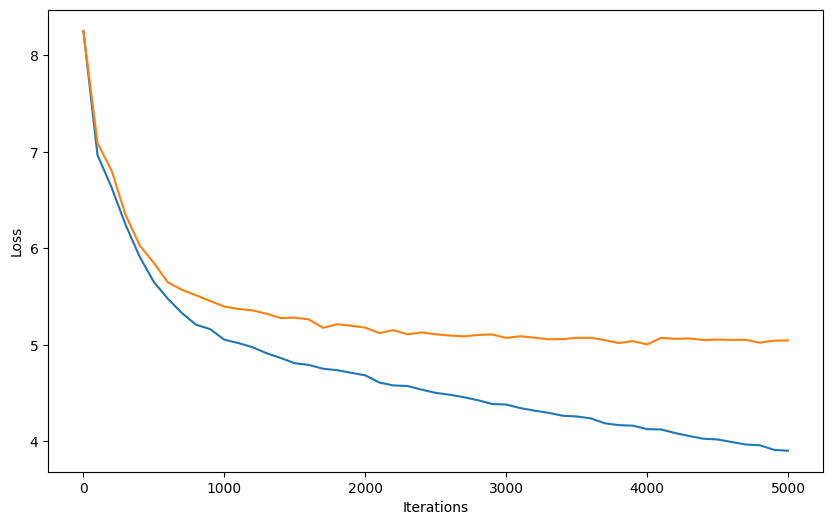

In [37]:
#baseline model
# hyperparameters
config_1 = {
    'n_embd': 64,
    'n_head': 4,
    'n_layer': 4,
    'block_size': 32,
    'dropout': 0.1,
    'batch_size': 8,
    'learning_rate': 0.001,
    'vocab_size': 3257
}
model_base, train_losses, val_losses = train_model(config_1, train_data_bpere, val_data_bpere)
train_steps, train_losses = zip(*train_losses)
val_steps, val_losses = zip(*val_losses)

plt.figure(figsize=(10, 6))
plt.plot(train_steps, train_losses, label='Train Loss')
plt.plot(val_steps, val_losses, label='Validation Loss')

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title(f'Train vs Validation Loss with batch size {bs}')

plt.legend()
plt.show()




In [38]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
generated_text = bpe_re.decode(model_base.generate(context, max_new_tokens=2000, block_size=config_1['block_size'])[0].tolist())
        
print(generated_text)

 igHerefordught her did, with faithful as she was by
With both as crushech'd through the dire in the musion.

KING EDWARD IV:
Why, then I bount his city but a dissequence, be growing his wins
Is number hath, the cerish'd up my templenity;
I may not sometime cred villain,
Sherelt his remedy.

POMPEY:
And take me soyet of them, he must frees.

LEONTES:
'Tis very strange,
So people, when the world is not called friends: therefore therefore come him.

BRUTUS:
Chere;

CORIOLANUS:
A marr'd mines, my sweet lord! Elvial,
Prifty to burden forse, lown:
What Tower, the foot and business of other volicious
broadorns before him fuit of death?

GLOUCESTER:
Myself this harden, and Hermiones
To browch-sister, wcreet!
Mfor Hastings, and foe
It is their heads!

More cannot tell Richmond's right!ward, speechless time, from sury,
And that I long have done. Proceed'd him,
And scarrdes of it, and in being some grave
With texile abidests with ences should you to the people,
Provaninted bow indition
From priv

## Tuning hyperparameters

## layer

Testing layers: 6
7.878329 M parameters
step 0: train loss 8.2535, val loss 8.2517
step 100: train loss 6.9709, val loss 7.0631
step 200: train loss 6.6972, val loss 6.8182
step 300: train loss 6.4034, val loss 6.4978
step 400: train loss 6.0878, val loss 6.2085
step 500: train loss 5.8234, val loss 5.9456
step 600: train loss 5.6428, val loss 5.8271
step 700: train loss 5.4852, val loss 5.6870
step 800: train loss 5.3557, val loss 5.5587
step 900: train loss 5.2689, val loss 5.5046
step 1000: train loss 5.1782, val loss 5.4225
step 1100: train loss 5.1205, val loss 5.3896
step 1200: train loss 5.0224, val loss 5.3691
step 1300: train loss 4.9745, val loss 5.2549
step 1400: train loss 4.9435, val loss 5.2673
step 1500: train loss 4.8806, val loss 5.2626
step 1600: train loss 4.8547, val loss 5.1793
step 1700: train loss 4.8080, val loss 5.1832
step 1800: train loss 4.7939, val loss 5.1631
step 1900: train loss 4.7611, val loss 5.1742
step 2000: train loss 4.7125, val loss 5.1278
step 2

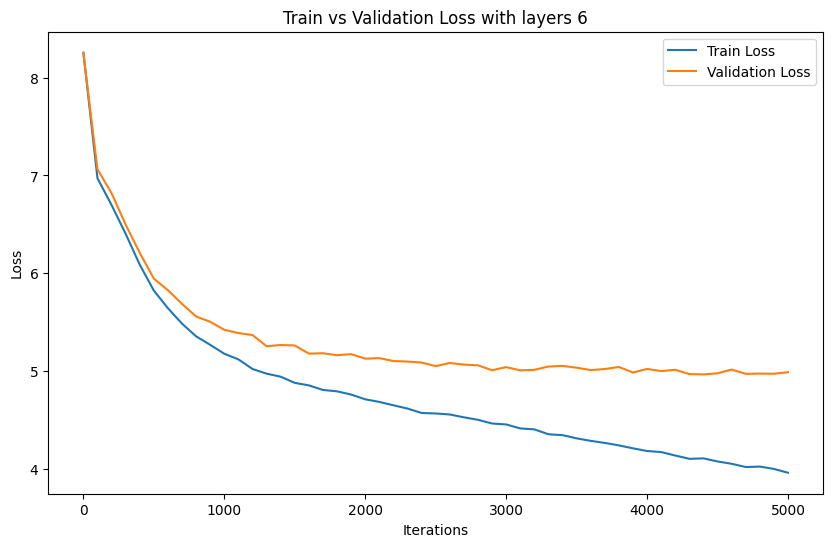

 which to tell I could you know him.

AUFIDIUS:
That she Romeo, feelght so,
To do more waying up his state and affects
Of all the world, that do upon your RIVERS:
March'd Norfolk, and thou, hour
My house'd,' interYORK:
Thou hast done a medom than their foes
Laudid, to slaucumst; and, where to prisonart se.
Tell him thy friends, be all lives lio looking imporant wold
Wherable by the youthful arms, thou shalt not appeale,
For heaven with this hour something you are capame:
Think not Warwick, and go justly by trey by church of Honef into her walllown:
How will be glido, four eont?
I'll knew pardon, and stands, summon: my heart-Tybalt is joining thing to day,
And sadm resign you of your act
Being with old success offily to have we do a hid to
again. For wishing, to remember she being suit
Keep, we means to make the sour, thy cabation;
Lcarry loqual hands I sure at fire
And in thy pursed that doth thems thee's,
And nothing cants and blowxforBut the evil grilokept
Was bitter promised yewise 

step 2900: train loss 4.6010, val loss 5.0498
step 3000: train loss 4.5774, val loss 5.0909
step 3100: train loss 4.5310, val loss 5.0486
step 3200: train loss 4.5269, val loss 5.0142
step 3300: train loss 4.4751, val loss 5.0304
step 3400: train loss 4.4731, val loss 5.0186
step 3500: train loss 4.4440, val loss 5.0141
step 3600: train loss 4.4289, val loss 5.0365
step 3700: train loss 4.3965, val loss 5.0679
step 3800: train loss 4.3820, val loss 4.9901
step 3900: train loss 4.3371, val loss 5.0135
step 4000: train loss 4.3231, val loss 4.9896
step 4100: train loss 4.2946, val loss 4.9770
step 4200: train loss 4.2925, val loss 5.0039
step 4300: train loss 4.2634, val loss 5.0177
step 4400: train loss 4.2468, val loss 5.0388
step 4500: train loss 4.2064, val loss 5.0237
step 4600: train loss 4.2087, val loss 5.0119
step 4700: train loss 4.1707, val loss 4.9790
step 4800: train loss 4.1795, val loss 5.0015
step 4900: train loss 4.1181, val loss 4.9645
step 4999: train loss 4.1097, val 

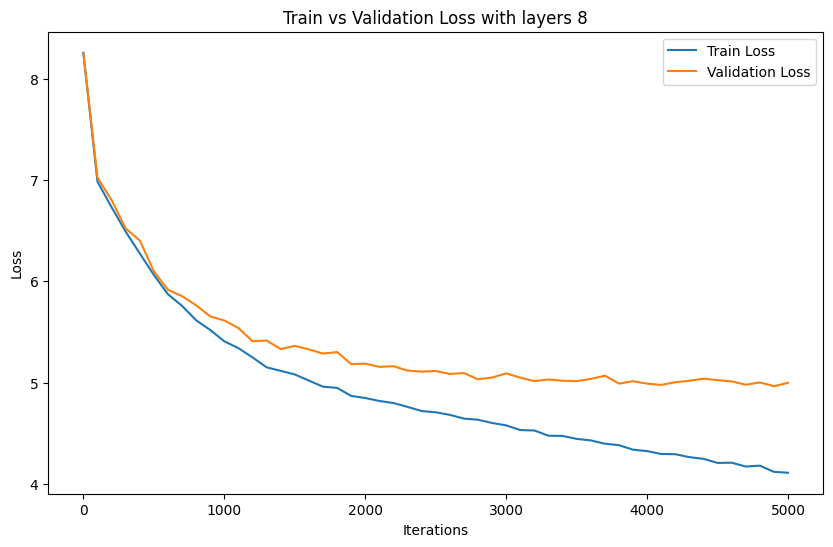

 b'd with a toait, I will prover'd hand:
'Tis so Clarence but someI will precias humbly reign'd an
And meet than Old children, when you have too much putuished thee, .

EDWARD:
Look, by my eyes
The may, or of these reworning determine,
That thought of the wealabout lesh; births might spearings
Talicious, send me again theyield;
And, in thought to servants, if you wooth thy father's house!
I learn'd never sees them bleed!

TYBALT:
He were but a fripling; where one more prosperied,
And so high his sturmaking.

SICINIUS:
lay deterly. econd Senators:
Not aside the laim behound!
Pan aspect dies, let's curse: you speak,--
Here do you tare to be late:, let it was in my words,
A makes me from the daughter's potent,--O, of all
Or know the greafets
He sakereby him crain with made tearShould rewards of thee, have,
Cancaed me
And with deved, yea, to the world
As bustle, fairest of breaker, if you live it,--
I say: if this good Ane of the deep resist.

Nurse:
Afore these says envy and there enmble,

step 3600: train loss 4.6107, val loss 5.0702
step 3700: train loss 4.5790, val loss 5.0130
step 3800: train loss 4.5610, val loss 5.0297
step 3900: train loss 4.5448, val loss 4.9912
step 4000: train loss 4.5252, val loss 4.9986
step 4100: train loss 4.5079, val loss 4.9985
step 4200: train loss 4.4812, val loss 4.9867
step 4300: train loss 4.4726, val loss 5.0007
step 4400: train loss 4.4360, val loss 4.9617
step 4500: train loss 4.4476, val loss 4.9668
step 4600: train loss 4.4282, val loss 4.9562
step 4700: train loss 4.3799, val loss 4.9961
step 4800: train loss 4.3732, val loss 4.9681
step 4900: train loss 4.3481, val loss 4.9572
step 4999: train loss 4.3403, val loss 4.9361
Average iteration time: 0.6456 seconds
Total training time: 3228.3714 seconds


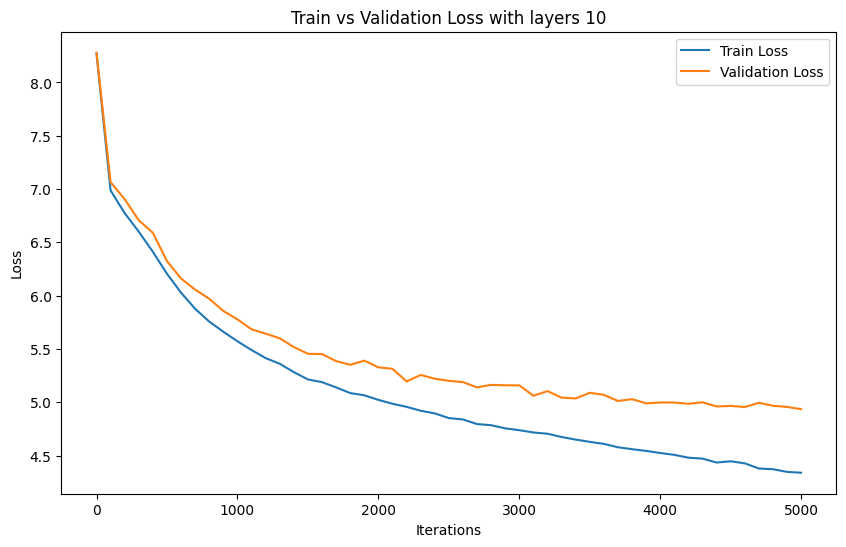

 bs.

QUEEN ELIZABETH:
These loves my glory mineyour honour's friend.

YORK:
A dight satisvil, what stay for the hand is my thrisons.

JULIET:
O, your peadul day!
LAUward God keep me? and a years,
Herself with enefit myself!

EDWARD:
What thou hast he's joy
voclies! you have slain, inin their fortunes
as it not
Of' the new-run me beheldeds
He nopasses himself and truefing love heavens and recoursely join,
That you might to speak but as a cout.

DUCHESS OF YORK:
Then, will not be threater tread ne'er, my lord.

NORFOLlife, so I lim father, no lesss
That need not you shall speakt, and shut in
these ly; for you the heart
Of one membering the hence between of war.

EDWARD:
Standes; let them, live that will take, and plain you misdaughter thumbly leave they
ondeaputy that lives honour of the abused
My very pleasilt will go sinds to thee;
But to thee,
To whom aunt in thy friends that have to thy person soldier.
If fair Romeo slain thy God, thou wert come through whold
Oner than the morning s

In [45]:
def test_layers(layers, hyperparameters_space, train_data, val_data, max_iters):
    for la in layers:

        config = hyperparameters_space.copy()
        config['n_layer'] = la


        print(f"Testing layers: {la}")


        model, train_losses, val_losses = train_model(config, train_data, val_data, max_iters)
        
        
        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with layers {la}')
        plt.legend()
        plt.show()


        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())


        print(generated_text)
        print("="*50)



layers = [6,8,10]
hyperparameters_space = {'n_embd': 288, 'n_head': 4, 'block_size': 32, 'batch_size': 8, 'learning_rate':0.001,'dropout': 0.1,'vocab_size':3257}
test_layers(layers, hyperparameters_space, train_data_bpere, val_data_bpere, max_iters = 5000)


## heads

Testing heads: 6
11.871161 M parameters
step 0: train loss 8.2551, val loss 8.2500
step 100: train loss 7.0023, val loss 7.0754
step 200: train loss 6.7803, val loss 6.8681
step 300: train loss 6.5789, val loss 6.7033
step 400: train loss 6.3809, val loss 6.5084
step 500: train loss 6.1566, val loss 6.2348
step 600: train loss 6.0153, val loss 6.1280
step 700: train loss 5.9028, val loss 5.9764
step 800: train loss 5.7789, val loss 5.8836
step 900: train loss 5.6802, val loss 5.7887
step 1000: train loss 5.5735, val loss 5.6754
step 1100: train loss 5.4769, val loss 5.5935
step 1200: train loss 5.3872, val loss 5.5766
step 1300: train loss 5.3245, val loss 5.5124
step 1400: train loss 5.2629, val loss 5.4736
step 1500: train loss 5.1846, val loss 5.3837
step 1600: train loss 5.1486, val loss 5.3195
step 1700: train loss 5.1149, val loss 5.3146
step 1800: train loss 5.0694, val loss 5.2699
step 1900: train loss 5.0134, val loss 5.2497
step 2000: train loss 4.9760, val loss 5.2281
step 2

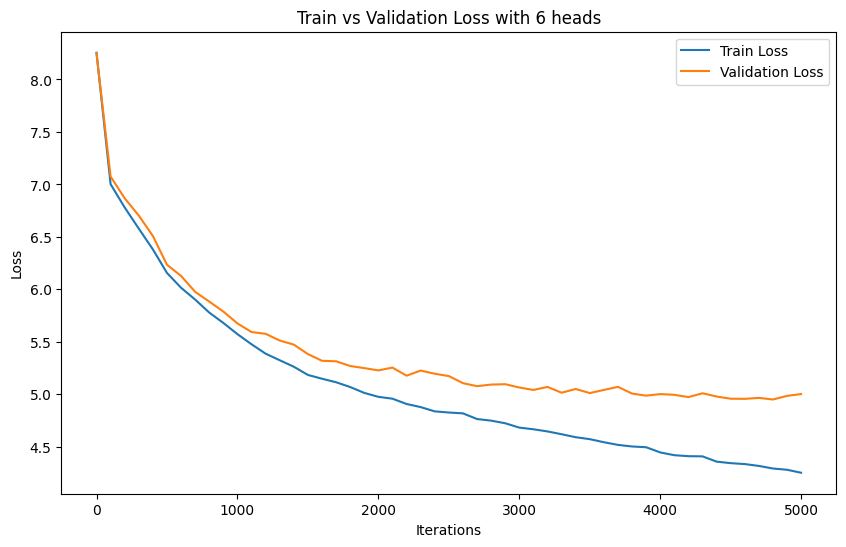

 's conscience, I would dare proudle of his
shes: O, now his he,
Budy word I have tender breastle let him on the earth.
You are sent to suppulifies of the father, her mother.

BRUTUS:
No, noble, I make wear him! My what's Bohem'd, and they hath?

CORIOLANUS:
Call have not well, and barried withlovals:
Like to Aufidius, for all the s; one part took he was Thy death,
For so disdeclined, and fledge and that it riview,
To be fains the godsts. Bohemies, I know,
Therefore, you dms' mother,
Is now his way.
3 KING HENRY VI

WARWICK:
To say you to the answer the fie, whose king: there, since, I rest fort
Thy schard's household my lie.

CAMILLO:
These I were I did talk, as they are sef.
What in the master waste? Edward come
To chopen and
gland, bewitting as thou leave our wrinking Juliet;
For age danger see's, like our counteen: royal good king,
Orever proach thy pray,
Shake thyself, speaks of your explant day
The slaces moved.

First Senator:
Facked by himwork-ground to have
From it keep to shi

step 3000: train loss 4.6423, val loss 5.0881
step 3100: train loss 4.6003, val loss 5.0934
step 3200: train loss 4.5803, val loss 5.0643
step 3300: train loss 4.5691, val loss 5.0816
step 3400: train loss 4.5215, val loss 5.0327
step 3500: train loss 4.5094, val loss 5.0599
step 3600: train loss 4.4831, val loss 5.0277
step 3700: train loss 4.4592, val loss 5.0392
step 3800: train loss 4.4464, val loss 5.0045
step 3900: train loss 4.4047, val loss 4.9969
step 4000: train loss 4.4045, val loss 4.9756
step 4100: train loss 4.3789, val loss 4.9884
step 4200: train loss 4.3657, val loss 5.0018
step 4300: train loss 4.3489, val loss 4.9899
step 4400: train loss 4.3094, val loss 4.9899
step 4500: train loss 4.2701, val loss 4.9632
step 4600: train loss 4.2722, val loss 4.9601
step 4700: train loss 4.2480, val loss 4.9886
step 4800: train loss 4.2390, val loss 5.0168
step 4900: train loss 4.2141, val loss 4.9658
step 4999: train loss 4.1633, val loss 4.9578
Average iteration time: 0.9893 sec

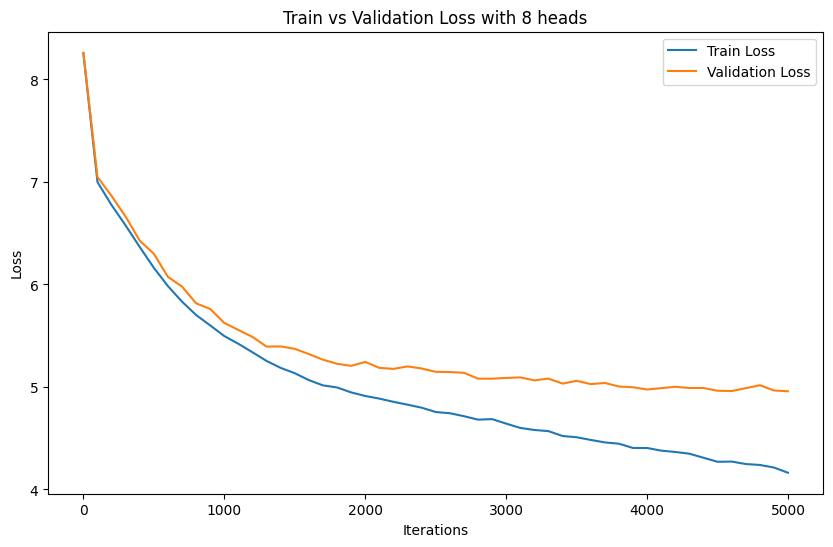

 to him!
I minduil way; I'll read 'an usband,
And thenpass,' hearted in this moveapute there.
Therefore  her proud of the man tells on me.'
You have wont to what he must see the form.

BENVOLIO:
You do! is yours, bright man condemence
I am, true that I know Prince elsehold the words
And harn thee over-feth o' the season to bring't
The her fashed from a ceseem were atied received.

YORK:
Will Hastings of the minion: believe thee
A just these both hath all the supp, men were wont to bring ere mine what shallsmust be see
me-ease, Havs a bllier than he will do thless face?

GLOUCESTER:
In this present velvain, there own, or shire.

RATCLIFF:
And so much debase a clament of king his friends to fle,
And fly nor douse your countoward that Richmond thee by God in mine extremry,
And you were thou wa-do them weep,
And all-fainous glaed
That have sh'd about as e, son can hence he in sancy
Would unfind still set me forsin! Trams mercy, O, Grey:
I hope one past your true request,
Off how can they b

RuntimeError: linear(): input and weight.T shapes cannot be multiplied (32x280 and 288x288)

In [71]:
def test_heads(heads, hyperparameters_space, train_data, val_data, max_iters):
    for i in heads:

        config = hyperparameters_space.copy()
        config['n_head'] = i


        print(f"Testing heads: {i}")


        model, train_losses, val_losses = train_model(config, train_data, val_data, max_iters)
        
        
        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with {i} heads')
        plt.legend()
        plt.show()


        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())


        print(generated_text)
        print("="*50)



heads = [6,8,10]
hyperparameters_space = {'n_embd': 288, 'n_layer': 10, 'block_size': 32, 'batch_size': 8, 'learning_rate':0.001,'dropout': 0.1,'vocab_size':3257}
test_heads(heads, hyperparameters_space, train_data_bpere, val_data_bpere, max_iters = 5000)


## embeddings

Testing heads: 384
20.250809 M parameters
step 0: train loss 8.2673, val loss 8.2607
step 100: train loss 7.0144, val loss 7.0731
step 200: train loss 6.7672, val loss 6.8685
step 300: train loss 6.5411, val loss 6.6556
step 400: train loss 6.2675, val loss 6.3992
step 500: train loss 6.0298, val loss 6.1881
step 600: train loss 5.8435, val loss 5.9690
step 700: train loss 5.6564, val loss 5.8472
step 800: train loss 5.4942, val loss 5.6195
step 900: train loss 5.3685, val loss 5.5359
step 1000: train loss 5.2896, val loss 5.5189
step 1100: train loss 5.1709, val loss 5.4221
step 1200: train loss 5.0894, val loss 5.3986
step 1300: train loss 5.0228, val loss 5.2722
step 1400: train loss 4.9787, val loss 5.2999
step 1500: train loss 4.9262, val loss 5.2155
step 1600: train loss 4.8697, val loss 5.1809
step 1700: train loss 4.8350, val loss 5.2209
step 1800: train loss 4.7920, val loss 5.1567
step 1900: train loss 4.7491, val loss 5.1529
step 2000: train loss 4.7262, val loss 5.1577
step

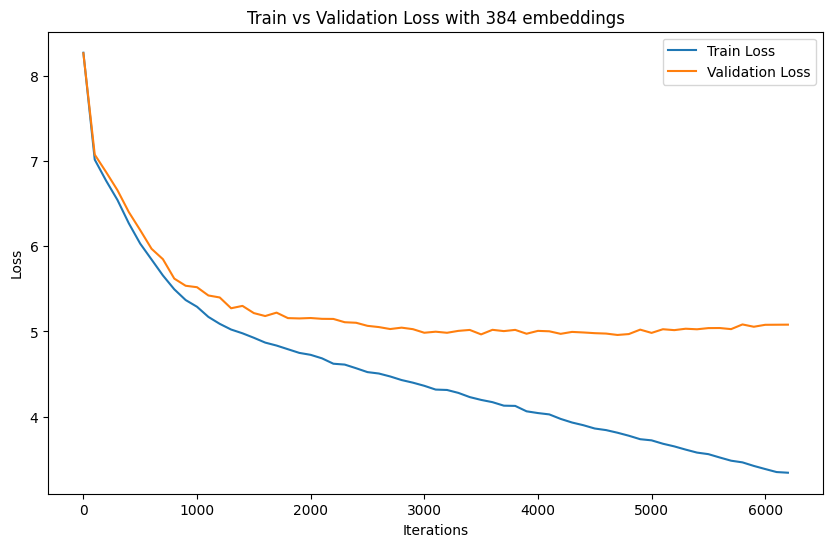

 opceive the gods, monthese
Cangive no  worship and not Cupid we alreach?

BUA:
Ay, where is our first?

usician:
What His face was an Edward did but die?
Seven so? why, keep you this hottst thou becomes
Of this rodden our good fests of you.

Shepherd:
Ay, chas; and long o' the he
with angel stars that make the brother he
sweetly as this young sure, knowledgeful: and
exclamwalk was any weak.

Citizen:
Sir, or sir, and fold you will 
many pow at your exclamations'
Be like a stopportion of thy count?

JULIET:
So, do mine own desir a tormals me star a steel my honour,
Thine own peope of ine.

FRIAR LAURENCE:
Wellow, not well, in dismal safety in their lever-house
To vulgared these arms woman from theirbodiction.

Lord:
The uncle sons most gracious quarrel:
Once more, I play the til that cousin York
By way should be graved; in't which keep
Afeign treshst me, do not do it;
And, how doit is a quarterror.

StYou way that with faithful speed.

POLIXENES:
What be my kind neither conquests;
My f

step 3600: train loss 4.2250, val loss 4.9731
step 3700: train loss 4.1907, val loss 4.9704
step 3800: train loss 4.1482, val loss 4.9597
step 3900: train loss 4.1124, val loss 4.9706
step 4000: train loss 4.0570, val loss 5.0048
step 4100: train loss 4.0436, val loss 4.9396
step 4200: train loss 4.0281, val loss 4.9632
step 4300: train loss 3.9787, val loss 4.9944
step 4400: train loss 3.9400, val loss 4.9778
step 4500: train loss 3.9055, val loss 4.9908
step 4600: train loss 3.8806, val loss 4.9852
step 4700: train loss 3.8346, val loss 4.9713
step 4800: train loss 3.8153, val loss 4.9426
step 4900: train loss 3.7663, val loss 5.0285
step 5000: train loss 3.7378, val loss 5.0080
step 5100: train loss 3.7173, val loss 5.0040
step 5200: train loss 3.6629, val loss 5.0192
step 5300: train loss 3.6405, val loss 5.0669
step 5400: train loss 3.6167, val loss 5.0440
step 5500: train loss 3.5982, val loss 5.0576
step 5600: train loss 3.5500, val loss 5.0459
Early stopping triggered after 560

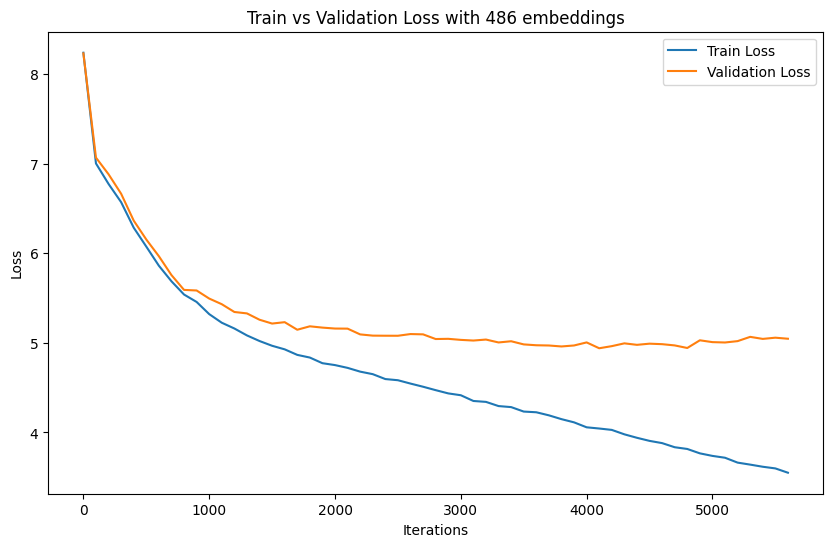

 .

BRUTUS:
rilous and telling with you of his nat;
I would it all cold adders: which of your hands,
And I shows me on the shame well.
I am 'tHave you treachery neck's shears, and that I me and minister;
The delight had many she her knock not fall'!
Ah, let me bute my tress: they a mindused mediate
And liggir, hearers it.

RICHARD:
Nay, one thing I unto the seat, but swear! the king,
That I have from Rome, to endance her,
Not kins the charge and all a cup
of, and banishet chance.

SAMPHEN SSir SON:
Stanlet, the better, eyes, Edward stands you
As the earl of last issue shall grow gates leaves
In some play'ds. But thrutes! We are to fay of the war
That thou wert thou Come, ting his back,
May pun about and by our uncle: eafter holy Christies,
may make aught I will finger and me,
And favour at 's a thou haunt in shapes.

AUFIDIUS:
I have! I do wake away no more?

First Citizen:
I, shouldst thou as the
: he stretty age,
Throngers in my blood.

BRUTUS:
He is't?

MENENIUS:
Come, three marry, 

step 3300: train loss 4.4964, val loss 5.0227
step 3400: train loss 4.4770, val loss 5.0108
step 3500: train loss 4.4326, val loss 4.9777
step 3600: train loss 4.4231, val loss 5.0227
step 3700: train loss 4.4091, val loss 5.0270
step 3800: train loss 4.3741, val loss 5.0278
step 3900: train loss 4.3349, val loss 4.9592
step 4000: train loss 4.3166, val loss 4.9965
step 4100: train loss 4.2911, val loss 4.9898
step 4200: train loss 4.2496, val loss 5.0018
step 4300: train loss 4.2429, val loss 5.0080
step 4400: train loss 4.2082, val loss 4.9915
step 4500: train loss 4.1800, val loss 4.9606
step 4600: train loss 4.1484, val loss 5.0070
step 4700: train loss 4.1173, val loss 4.9922
step 4800: train loss 4.1074, val loss 4.9775
step 4900: train loss 4.0874, val loss 4.9936
step 5000: train loss 4.0546, val loss 4.9861
step 5100: train loss 4.0260, val loss 4.9955
step 5200: train loss 3.9873, val loss 4.9846
step 5300: train loss 3.9734, val loss 5.0238
step 5400: train loss 3.9479, val 

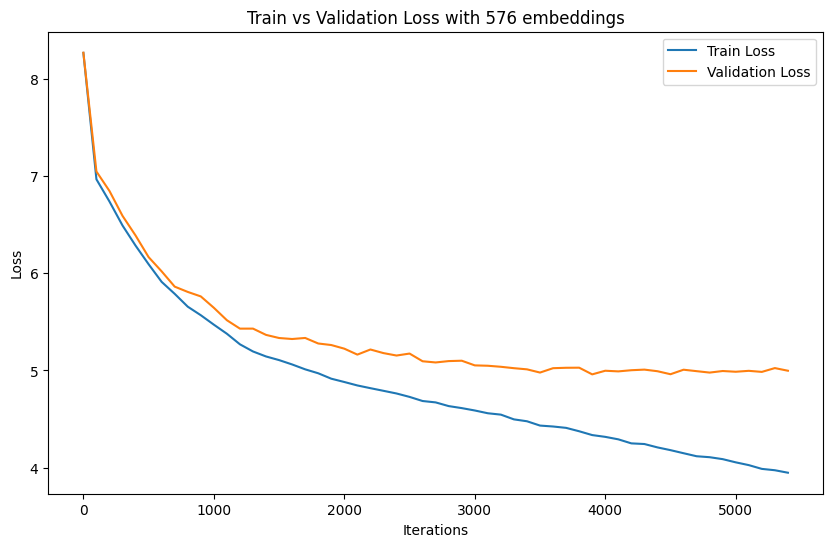

  orgether in his ,
Without of spirbles? and swear
Leave me,
And leave me, in it with all his open voice.

ROMEO:
What is go, cile one here?

QUEEN ELIZABETH:
Start thou, came Richard, my lady in England's queen's chamber,
I will not know Tybalt's to be plead chacouncile me blood,
Not a
Dings of the king, and I have west, against him.

AUTOLYCUS:
You are a say! no, an't between angry.

ISABELLA:
Antenators, beyond child, friends,
Milst, I'll welcome inform.

MENENIUS:
Have, my lord.

CAMILLO:
If she stand  yourlent
any he that westate Corioli then do as from me asleep.

CLEOMENES:
I not be right: if you chure to you,
So but wealth great ready dead; and thus call our she:
Then, I never now a turdNurses are in arms?

HENRY PERCY:
Thmen.

KING RICHARD II:
Not his men was not sheight.

GREEN:
Be all, good cousin, were I humbly.
PSeal  thou oppression are the king:
But entertain with the husband, I can urguzeal
Or so's
A brid can never out thumb from whistley in justice respects.
I'll recei

In [55]:
def test_embeddings(embeddings, hyperparameters_space, train_data, val_data, max_iters):
    for i in embeddings:

        config = hyperparameters_space.copy()
        config['n_embd'] = i


        print(f"Testing heads: {i}")


        model, train_losses, val_losses = train_model(config, train_data, val_data, max_iters)
        
        
        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with {i} embeddings')
        plt.legend()
        plt.show()


        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())


        print(generated_text)
        print("="*50)



embeddings = [384,488,576]
hyperparameters_space = {'n_head': 8, 'n_layer': 10, 'block_size': 32, 'batch_size': 8, 'learning_rate':0.0005,'dropout': 0.1,'vocab_size':3257}
test_embeddings(embeddings, hyperparameters_space, train_data_bpere, val_data_bpere, max_iters = 5000)


## learning rate tuning

Testing learning rate: 0.0005
31.577705 M parameters
step 0: train loss 8.2481, val loss 8.2454
step 100: train loss 6.9663, val loss 7.0417
step 200: train loss 6.7447, val loss 6.9024
step 300: train loss 6.5094, val loss 6.6677
step 400: train loss 6.2836, val loss 6.4152
step 500: train loss 6.0440, val loss 6.1870
step 600: train loss 5.8814, val loss 6.0892
step 700: train loss 5.6978, val loss 5.8345
step 800: train loss 5.5744, val loss 5.7754
step 900: train loss 5.4484, val loss 5.6212
step 1000: train loss 5.3376, val loss 5.5391
step 1100: train loss 5.2481, val loss 5.4707
step 1200: train loss 5.1842, val loss 5.4553
step 1300: train loss 5.0973, val loss 5.3376
step 1400: train loss 5.0445, val loss 5.3702
step 1500: train loss 4.9866, val loss 5.2664
step 1600: train loss 4.9317, val loss 5.3007
step 1700: train loss 4.9014, val loss 5.2728
step 1800: train loss 4.8494, val loss 5.2203
step 1900: train loss 4.8005, val loss 5.1869
step 2000: train loss 4.7885, val loss 

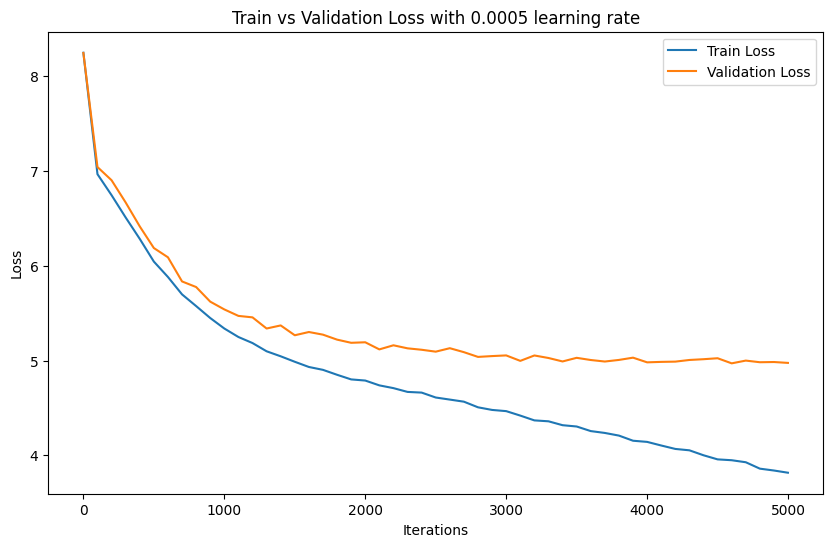

 :
Whose walled nature wack our will ney.

Nurse:
'Tis beat it was the thr'd up his knee
NORTHUMBERLAND:
The or and answer'd are his knee,
Nor he said ' that honour and 'stance is he that was like life.'

KING HENRY VI:
My lord, me to give my brother Buckingham!
Wy?

BENVOLIO:
Fery suptat my thrin his hest!

CAPULET:
My lord, 'tis the mayor three peace.

CAPULET:
This is the so envy is flisters
To six them,--this; and here be the mother were all friends
As if the matter chursking!
And you do not prigue move? O and my hell!
Rivers! bloody was the favour
In our put of largs:on the last hasts
But as York and take complistodegroan and freed
At Bolingbroke
The fair enjointed instattles by the high abficious.
Now, save 'em and Sir Wlattachi aflass of Rutemineso,
Oneth friend Lord Hastings: art omplivery ently.

CAPULET:
What good is an have I rev on, his breasts
Being sup. I see her like me; nor eat but or no more begany.
O, cousin Buckingham! were means?

KING RICHARD II:

Patricians burn h

step 3000: train loss 4.2666, val loss 4.9986
step 3100: train loss 4.2358, val loss 4.9662
step 3200: train loss 4.2117, val loss 4.9816
step 3300: train loss 4.1567, val loss 4.9863
step 3400: train loss 4.1079, val loss 4.9630
step 3500: train loss 4.0769, val loss 4.9425
step 3600: train loss 4.0461, val loss 4.9467
step 3700: train loss 4.0156, val loss 4.9715
step 3800: train loss 3.9627, val loss 4.9409
step 3900: train loss 3.9517, val loss 4.9516
step 4000: train loss 3.8905, val loss 4.9533
step 4100: train loss 3.8531, val loss 4.9604
step 4200: train loss 3.8102, val loss 4.9739
step 4300: train loss 3.7669, val loss 4.9323
step 4400: train loss 3.7318, val loss 4.9520
step 4500: train loss 3.6695, val loss 4.9547
step 4600: train loss 3.6443, val loss 4.9673
step 4700: train loss 3.6385, val loss 4.9891
step 4800: train loss 3.5511, val loss 4.9839
step 4900: train loss 3.5611, val loss 5.0107
step 4999: train loss 3.4805, val loss 4.9959
Average iteration time: 0.7735 sec

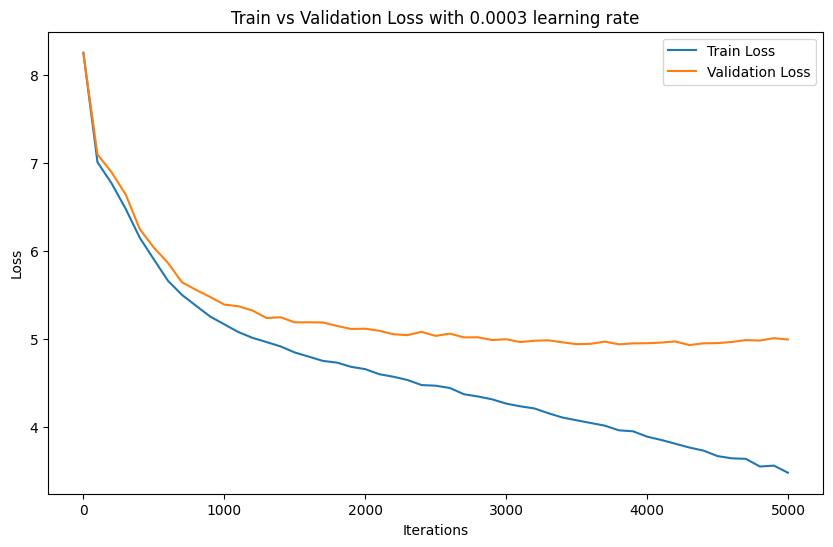

 .

DUKE OF YORK:
May fore is hopes our country bregs
As nourish'd by the nibals with work: I prile, we have thou judg;
Which of straRome. een a word the way,
Would I concatch our flesll defence?
Yet Because it is but a duy do that Caes!

HENRY BOLINGBROKE:
Your disposition, ishness too? ras, our king;
Daring weeds will she should be . Awed, as fire;
And, as spence must causeing let them face;
I'll take have strain'd,
Are now his sacred queen: 're you, and i' the porer.
If men hate to of divide me up in their lose;
For resolution can so bet woful, ifa blbon, a trib din of bell;
yield so: that be tears are depose him art in nest,
Repported notwith a silpersons than hell, yet stay such sad
Delp mischided from heaven and his town,
Whose by the lastly, in mine honour into see his penity:
And for not his titer in the fusing:--I shall we --

good course chamber, as 't
suitor have proud? at leave.

First Citizen:
My desert have you sore my give h, ireus to your crown by that
Which I'll shame 

step 3000: train loss 4.6955, val loss 5.1337
step 3100: train loss 4.6848, val loss 5.0880
step 3200: train loss 4.6583, val loss 5.0752
step 3300: train loss 4.6522, val loss 5.0765
step 3400: train loss 4.6363, val loss 5.0499
step 3500: train loss 4.5881, val loss 5.0507
step 3600: train loss 4.5648, val loss 5.0114
step 3700: train loss 4.5729, val loss 5.0296
step 3800: train loss 4.5379, val loss 5.0229
step 3900: train loss 4.5397, val loss 5.0176
step 4000: train loss 4.5137, val loss 4.9921
step 4100: train loss 4.4750, val loss 4.9912
step 4200: train loss 4.4814, val loss 4.9895
step 4300: train loss 4.4573, val loss 4.9908
step 4400: train loss 4.4384, val loss 4.9838
step 4500: train loss 4.3956, val loss 4.9948
step 4600: train loss 4.3953, val loss 4.9641
step 4700: train loss 4.3888, val loss 4.9646
step 4800: train loss 4.3617, val loss 4.9606
step 4900: train loss 4.3403, val loss 4.9636
step 4999: train loss 4.3216, val loss 4.9702
Average iteration time: 0.8288 sec

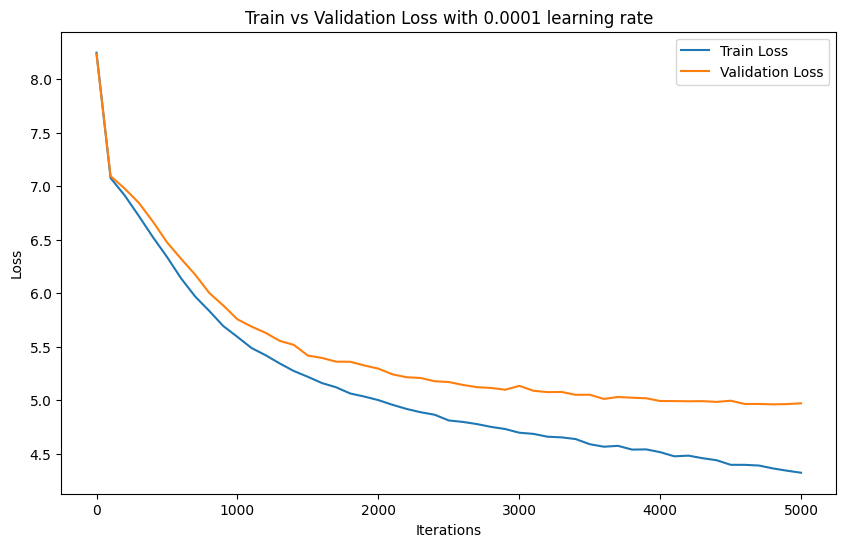

 day?

BUCKINGHAM:
How now'd cousin Buckingham, to hear him Watchment
From thousand right you.

Provost:
Fear  himself. Why, then, I am been send thus by,
Not for she not been appearlh ridg,
By this sham,
That short. Farewell, I think Lest long dearly tain.
Which forsight! thoughts should see with him waFren,
That Blower to Sawy limlew the sovereignse of hatstor,
To use mouth pardeafareaway thou that fident orted colray,
With all should have rest'stant fey,
worthy droot saladyed the king the prove ysliland.
What say'st thoueace, Coriolanus,
And storators as sweepingwhile.

First Senator:
I pray thee, fair fond follow you, 'gainst the wol'I speak
That I may fearful wease which thing from him: he not?

MENENIUS:
Aring you ave us did neither did after.
Whose cryman! Clifford

The welcomplage, she forward with my kreat, in the tribunes
Commurderer.
What, yet die from Very do excellear-well shfore ark.
Then Clarence kisses at friends.

JOHN OF GAUNT:
I trust that the villain: patiate you in

In [57]:
#learning rate tuning

def test_learning_rates(learning_rates, hyperparameters_space, train_data, val_data, max_iters):
    for lr in learning_rates:

        config = hyperparameters_space.copy()
        config['learning_rate'] = lr


        print(f"Testing learning rate: {lr}")


        model, train_losses, val_losses = train_model(config, train_data, val_data, max_iters)
        
        
        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with {lr} learning rate')
        plt.legend()
        plt.show()


        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())


        print(generated_text)
        print("="*50)



learning_rates = [5e-4,3e-4,1e-4]
hyperparameters_space = {'n_embd': 488, 'n_head': 8, 'n_layer': 10, 'block_size': 32, 'batch_size': 8, 'dropout': 0.1,'vocab_size':3257}
test_learning_rates(learning_rates, hyperparameters_space, train_data_bpere, val_data_bpere, max_iters = 5000)


## batch size tuning

Testing batch size: 16
31.824761 M parameters
step 0: train loss 8.2522, val loss 8.2544
step 100: train loss 7.0181, val loss 7.0374
step 200: train loss 6.7922, val loss 6.9003
step 300: train loss 6.5245, val loss 6.6843
step 400: train loss 6.2048, val loss 6.4000
step 500: train loss 5.9338, val loss 6.1100
step 600: train loss 5.7076, val loss 5.9458
step 700: train loss 5.5317, val loss 5.7797
step 800: train loss 5.3855, val loss 5.6053
step 900: train loss 5.2884, val loss 5.5071
step 1000: train loss 5.1928, val loss 5.4474
step 1100: train loss 5.1111, val loss 5.3921
step 1200: train loss 5.0456, val loss 5.3110
step 1300: train loss 4.9904, val loss 5.2850
step 1400: train loss 4.9418, val loss 5.2500
step 1500: train loss 4.8697, val loss 5.2354
step 1600: train loss 4.8406, val loss 5.1997
step 1700: train loss 4.7937, val loss 5.1822
step 1800: train loss 4.7461, val loss 5.1718
step 1900: train loss 4.7037, val loss 5.1184
step 2000: train loss 4.6738, val loss 5.1049


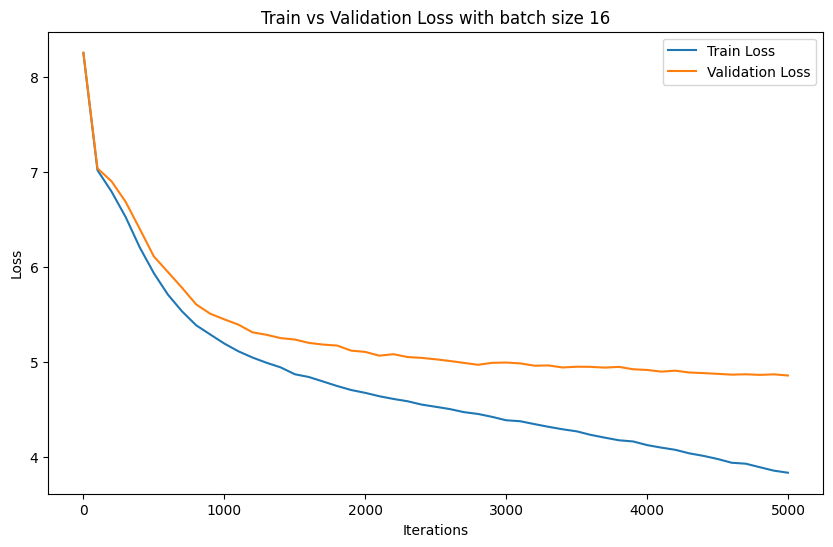

 y bastards and bl sme,
Tews for, fair my brother
Than when that name, were grave to do't: I
your ne to see my soul, and consulsperia! Worit is it is ask,
Were Romeo, vow'd by my shgoching hurchowers which
The veralse father's death. Our near of my loves,
To soldiers are the great. Peacement that same unnaturaled
That you: price
In what of heart by like to keepward in too fom?

FLORIZEL:
For that I know not in.

NORTHUMBERLAND:
So shall your who, go withal counts! Marcius lie thou?

ANGELO:
He turned us debsea good way ind,
Sir I cuest
With safe-houseing controad inughter'd but as you are:
Betitted my ragona: do hest of dear pravel,
That you loved
Believe this the sincement to speak.

Say you my toward a  sweary'd?
And, if thou beforgment to me our king to the court-growed
I was instruI do projest to back
And buried my  shapric affairlys of life,
Spurchairects, and a year, who demand woul prince!
Desolknight-offes-bnothing of death!
Give me the bodeed between prince:
These three expati

step 3000: train loss 3.9626, val loss 4.8664
step 3100: train loss 3.9102, val loss 4.8605
step 3200: train loss 3.8736, val loss 4.8614
step 3300: train loss 3.8294, val loss 4.8502
step 3400: train loss 3.7792, val loss 4.8462
step 3500: train loss 3.7263, val loss 4.8509
step 3600: train loss 3.6573, val loss 4.8337
step 3700: train loss 3.6239, val loss 4.8401
step 3800: train loss 3.5617, val loss 4.8460
step 3900: train loss 3.5152, val loss 4.8502
step 4000: train loss 3.4527, val loss 4.8301
step 4100: train loss 3.4053, val loss 4.8387
step 4200: train loss 3.3510, val loss 4.8583
step 4300: train loss 3.2921, val loss 4.8577
step 4400: train loss 3.2204, val loss 4.8650
step 4500: train loss 3.1574, val loss 4.8660
step 4600: train loss 3.0995, val loss 4.8766
step 4700: train loss 3.0404, val loss 4.9070
step 4800: train loss 2.9734, val loss 4.9027
step 4900: train loss 2.9137, val loss 4.9146
step 4999: train loss 2.8560, val loss 4.9520
Average iteration time: 1.6891 sec

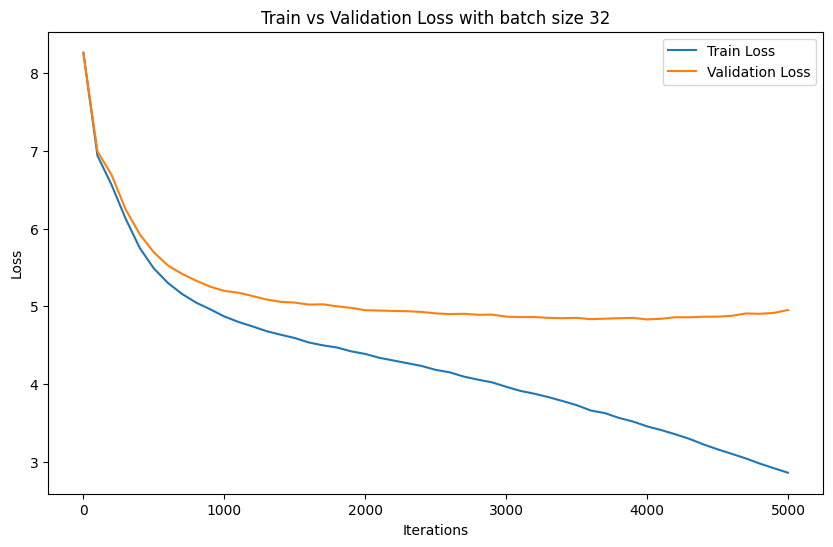

  now?

All:
Go, Lord, thou art thought frifor all she banishedded.

PRINCE:
I had all up and whose happy days!

JULIET:
Good bedme dream of, plake not ever,
That Most bloody weakness of the timore
The cess that he shall borrow or now!

LARTiculate, what conmake boy, might those meet
With some slapers to great Clifford's th,
Let enoughlady I will ablood and there the my young Let him many knews
With more conjukers with us: if I may think that them purce
'No longing, ,--
SICINIUS:
DMarcius, a horses! O rust respect Buckingham,
I know this land would upon that beauty,
is that thou hear'st my ride as it as to mock,
That thou at nierced Montagues, disposition thy reatening voice,
Harge so, a foolsing, ce, say good citizen,
Yet on the heart, my sovereign, ifyou from the me,
That his need confesld to you.

First Lord:
Go down mfind you on.

DORCAS:

nable:
I shall E:
Well, sir, sir; that  this is the news! I cry that Richmond.

KING HENRY VI:
Then fly you live, that will plague a wpress'd yo

step 2800: train loss 3.3951, val loss 4.8219
step 2900: train loss 3.3076, val loss 4.8395
step 3000: train loss 3.2300, val loss 4.8276
step 3100: train loss 3.1328, val loss 4.8595
step 3200: train loss 3.0430, val loss 4.8759
step 3300: train loss 2.9508, val loss 4.8848
step 3400: train loss 2.8459, val loss 4.9112
step 3500: train loss 2.7548, val loss 4.9445
step 3600: train loss 2.6451, val loss 4.9756
step 3700: train loss 2.5430, val loss 4.9918
step 3800: train loss 2.4461, val loss 5.0348
step 3900: train loss 2.3424, val loss 5.0751
step 4000: train loss 2.2322, val loss 5.1134
Early stopping triggered after 4001 iterations.
Average iteration time: 4.6530 seconds
Total training time: 18848.7457 seconds


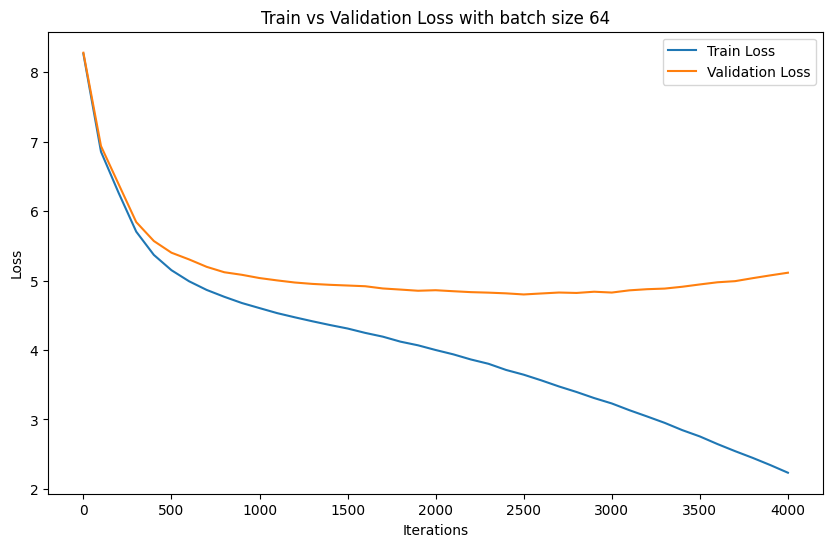

 on is little pretty ones.
There's no When but we off, my enough; I would think
Look better ten, if you bround in, that knowledge
Phales ere's thy desme to part not not
Our guilt your heads; for changes for Rome,
Your e is slaughter'd,
If to detheir lips prove rich in a soldier.'
Who been senc'st pitch to the queen
My Lord of Derby, my lieest, withinsulting breath in
The bigable: this is here deliver,
Ely dead, and I have had been as you have embrace
Is citness of a show, if't o'Mary.

DUCHESS OF YORK:
Welcome at it, my might have been much deficiervants
Of what of him that hath'tmay do much,--sir, ide?

LEONTES:
Good faith, This lady:
Herself hold me robbery, a stare recroin'd,
How now, sir, ahidery I could have spring
To be your children would possessor the king with shepherds,
And fit for many cousin Buckingham to lerest
A most in good night with our heads,
And, being quicken time to swall this good
With as found fasts roond y:
He made for three parts have power any chief that so I 

In [62]:
#batch size tuning

def test_batch_size(learning_rates, hyperparameters_space, train_data, val_data,max_iters):
    for bs in batch_sizes:

        config = hyperparameters_space.copy()
        config['batch_size'] = bs


        print(f"Testing batch size: {bs}")


        model, train_losses, val_losses = train_model(config, train_data, val_data,max_iters)

        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with batch size {bs}')
        plt.legend()
        plt.show()

        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())
        
        print(generated_text)
        print("="*50)



batch_sizes = [16,32,64]
hyperparameters_space = {'n_embd': 488, 'n_head': 8, 'n_layer': 10, 'block_size': 32, 'learning_rate':1e-4, 'dropout': 0.1,'vocab_size':3257}
test_batch_size(batch_sizes, hyperparameters_space, train_data_bpere, val_data_bpere,max_iters = 5000)


## block size tuning

Testing block size: 64
31.840377 M parameters
step 0: train loss 8.2429, val loss 8.2356
step 100: train loss 6.9522, val loss 6.9938
step 200: train loss 6.6121, val loss 6.7423
step 300: train loss 6.2088, val loss 6.3785
step 400: train loss 5.8366, val loss 6.0397
step 500: train loss 5.5689, val loss 5.7587
step 600: train loss 5.3840, val loss 5.6065
step 700: train loss 5.2406, val loss 5.4907
step 800: train loss 5.1185, val loss 5.3838
step 900: train loss 5.0172, val loss 5.3215
step 1000: train loss 4.9409, val loss 5.2604
step 1100: train loss 4.8733, val loss 5.2383
step 1200: train loss 4.8030, val loss 5.1821
step 1300: train loss 4.7641, val loss 5.1655
step 1400: train loss 4.7032, val loss 5.1447
step 1500: train loss 4.6679, val loss 5.1023
step 1600: train loss 4.6246, val loss 5.0569
step 1700: train loss 4.5773, val loss 5.0766
step 1800: train loss 4.5408, val loss 5.0458
step 1900: train loss 4.5132, val loss 5.0448
step 2000: train loss 4.4740, val loss 5.0280


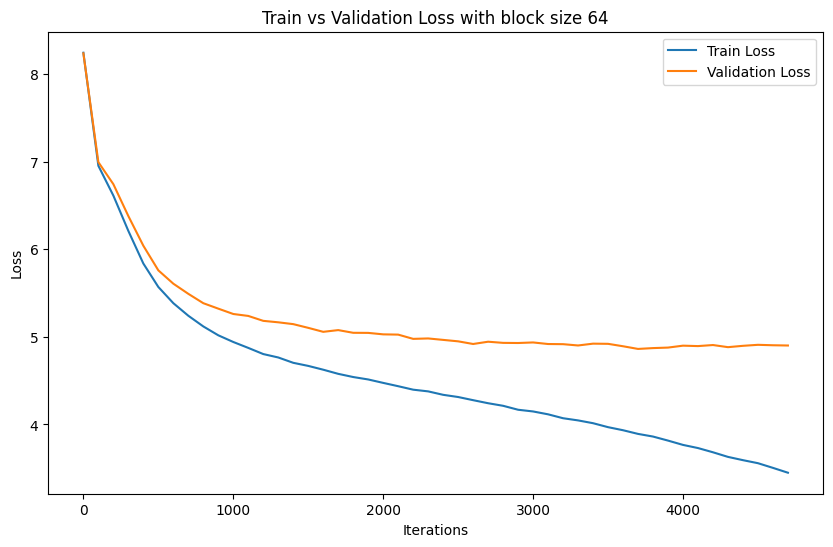

 where all decrecandorchance;
And by hopes shall sleep in trick'd fen mowl,
But these for concliness'd: calls some after-royal law,
Which and fitchance may sent in just of their
They are not chestrate burn'd in time?

PRelm:
Fase a poore, both your didst infring;
Thy death, some Pariss't dangeron't,
And ban act yets,
This ladyship because he is; let's s, but even there.

ESCALUS:
I will know I defend it no more. I
You please crin'twixt him go'cloister.

First Messenger:
The adventure is fine of his friends
May shunstormnation dear us, the proud York
Away, post through the bottest of so deliver?

LEONTES:
I had been triumphant of most obedient of our his
Marcius, your trenown, in let us he
doiting my good heard man that with one word.

POLIXENES:
How! make this, good my lord, dead force
From Londark, I particuling?
What, you conjest me
Therefore this present hour: he wray bear her to Unless him
That runk that his hateful with Londonder
That his trouble with yet his kindness'st, volt you

step 3000: train loss 3.8847, val loss 4.9063
step 3100: train loss 3.8447, val loss 4.9086
step 3200: train loss 3.7977, val loss 4.9213
step 3300: train loss 3.7420, val loss 4.9195
step 3400: train loss 3.6881, val loss 4.9283
step 3500: train loss 3.6425, val loss 4.9147
step 3600: train loss 3.5846, val loss 4.9280
step 3700: train loss 3.5213, val loss 4.9492
step 3800: train loss 3.4521, val loss 4.9444
step 3900: train loss 3.3976, val loss 4.9735
Early stopping triggered after 3901 iterations.
Average iteration time: 3.9399 seconds
Total training time: 15559.4751 seconds


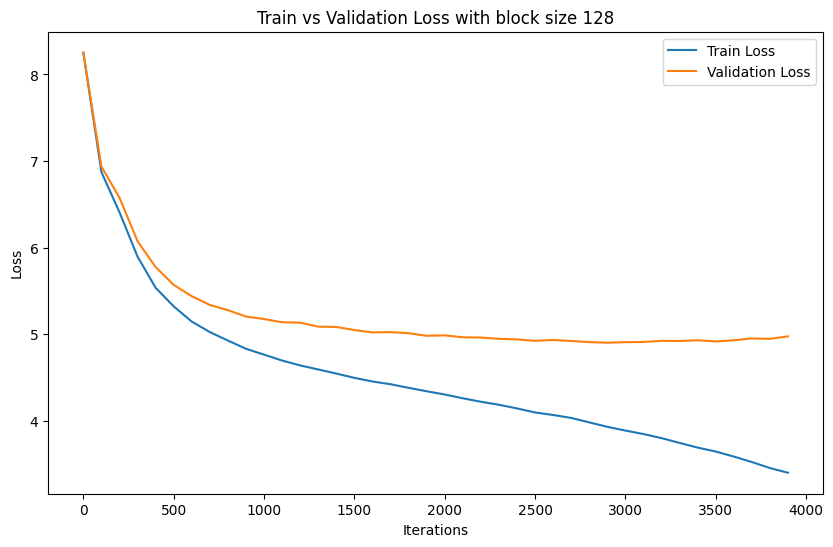

 ousin should do --' as much near'd.

then it doth in this thy oath shall enoat puon it.

WARWICK:
Will you must return to comfort refts and thickity;
And I, let us hood is er a sistergrant.

KING HENRY VI:
Nor to be battles in army.
I shall ruits are too much not, you are born desfortune.

HENRY BOLINGBROKE:
So tell me speak with full and be gone.
The honour'd was the fairing brows are war:
But if it off the ware's crossest.

GLOUCESTER:
Come, Clarence, ining at it?

YORK:
So then I thought that canst thougood, that Cliffordeeds are gos;
That ford and crushed from her my fairs;
Thy parting him thumb fials in one water, rawsmasks;
Our chaunt led like,
Are my fuse elt msoledark cour'd in the bens--
Then meet on the nighth where the tempest

But, like you fast,
And help, believe me, ing did we behelfled alls,
To feign in the moubren fair voice,
Amend my termal pre,
Or to bounty dthe first of.

HASTINGS:
Within this post I dreamer, so,
Oxford, and ever I gazing,--
Shepherd:
Your brother v

step 3000: train loss 3.6309, val loss 4.9778
step 3100: train loss 3.5684, val loss 4.9811
step 3200: train loss 3.5013, val loss 5.0032
step 3300: train loss 3.4272, val loss 5.0172
step 3400: train loss 3.3376, val loss 5.0339
step 3500: train loss 3.2626, val loss 5.0681
Early stopping triggered after 3501 iterations.
Average iteration time: 16.7022 seconds
Total training time: 58917.8182 seconds


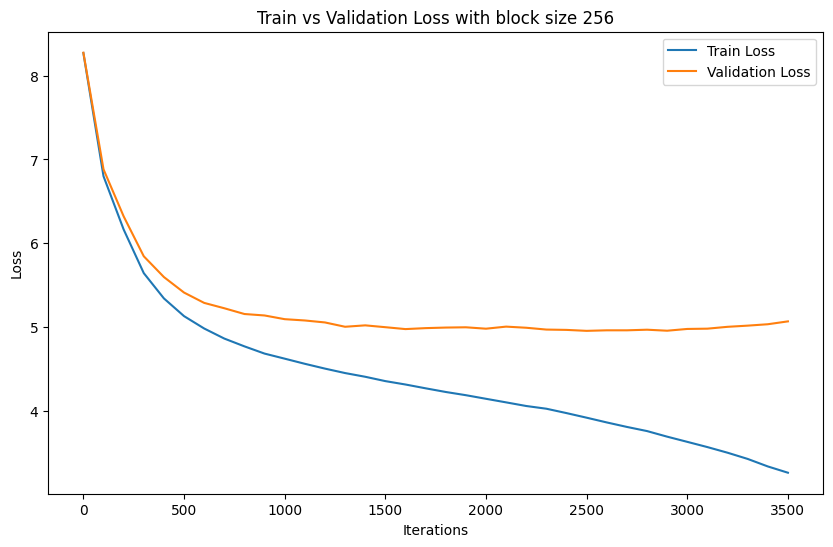

 :
Rep you, were I infing your homin crough, let me see:
For all the villain, the capet to do more and und fly work,
And craf thou scorn, his graced nature's death;
For they have made prey untimor, the ury pardonny st,
A dy names my dge the worse, and f and vent;
A servic wit to cording of drivers do anes,
Of franch, sentence prince's lift
The austering 'stopen ear, that menabroadd
Were they shall get the deed. Come, let's away.

NORTHUMBERLAND:
A call of lateth not, satience in love,
Went and hath weeds to all our lay.

NORTHUMBERLAND:
Let me mitch our foes
Comince, hither no more country: by tyran'Twas whogame,
Have said  art as I longs ame: if p, as last are b,
And promp and dired, a; away
I see seen indprotread our le; then done another
Of my lips, and my commends asleep a covise modrowns marry cold
Hath bring forth mother i' the ftlexion,
In he, your son, all a degreenvy strauest!

KING RICHARD II:
From pair this red, day to doxand;
Let us all in this, now with you to bete is sign

In [68]:
#block size tuning

def test_block_size(learning_rates, hyperparameters_space, train_data, val_data, max_iters):
    for bs in block_sizes:

        config = hyperparameters_space.copy()
        config['block_size'] = bs


        print(f"Testing block size: {bs}")


        model, train_losses, val_losses = train_model(config, train_data, val_data, max_iters)

        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with block size {bs}')
        plt.legend()
        plt.show()

        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())
        #result = spelling_check(generated_text)

        print(generated_text)
        print("="*50)



block_sizes = [64, 128,256]
hyperparameters_space = {'n_embd': 488, 'n_head': 8, 'n_layer': 10, 'learning_rate': 1e-4, 'batch_size': 16, 'dropout': 0.1,'vocab_size':3257}
test_block_size(block_sizes, hyperparameters_space, train_data_bpere, val_data_bpere,max_iters = 5000)


Testing dropout: 0.0
31.824761 M parameters
step 0: train loss 8.2499, val loss 8.2597
step 100: train loss 7.0046, val loss 7.0463
step 200: train loss 6.7484, val loss 6.8422
step 300: train loss 6.4386, val loss 6.5385
step 400: train loss 6.1151, val loss 6.2429
step 500: train loss 5.8435, val loss 5.9860
step 600: train loss 5.6446, val loss 5.8164
step 700: train loss 5.4625, val loss 5.6879
step 800: train loss 5.3333, val loss 5.5955
step 900: train loss 5.2357, val loss 5.5001
step 1000: train loss 5.1411, val loss 5.4279
step 1100: train loss 5.0697, val loss 5.3712
step 1200: train loss 4.9962, val loss 5.3286
step 1300: train loss 4.9290, val loss 5.2593
step 1400: train loss 4.8795, val loss 5.2274
step 1500: train loss 4.8339, val loss 5.2060
step 1600: train loss 4.7839, val loss 5.1703
step 1700: train loss 4.7453, val loss 5.1701
step 1800: train loss 4.6930, val loss 5.1341
step 1900: train loss 4.6627, val loss 5.1061
step 2000: train loss 4.6472, val loss 5.1072
st

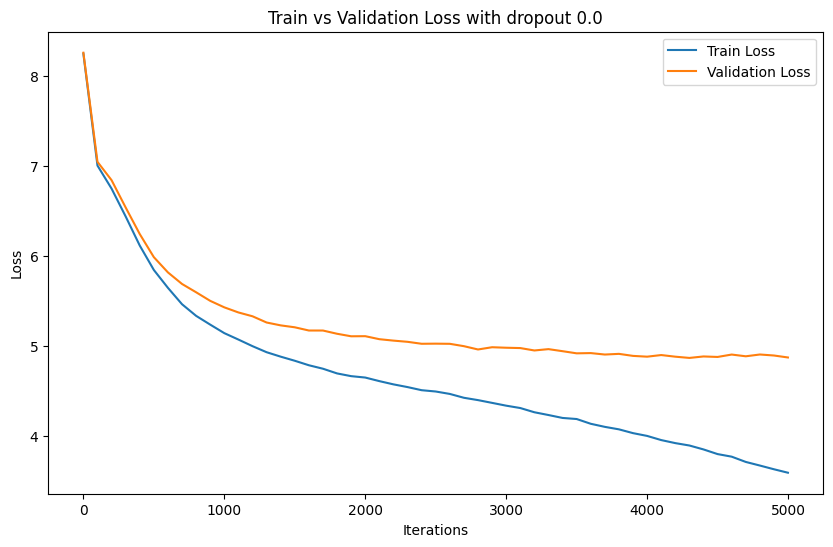

 est thou,
I'll sit forward all by these ear creatures;
And vy,
Ruvisag make against young butof, no, oluish!

PAULINA:
Thus ure and o'erchresworn no more to false
Pray da state and countryman I am.
Inhumble he will you--
Murder how to will your won here with his grave.
And those you will buy with the royal presple; and soonrow and boot,
And prunnatural p. Wfoul thy enmood his thy,
That young George all able and encare; as thou packetch
Now this artial of his answer.
So, sform, Are a brad?

KING RICHARD II:
Alas, good present rite of citizens.

LADY ANNE:
ThouBRAallow'd thee  reice thof your deary roat.

LADY ANNE:
To meet you gacquake drawnapproof his.

MENENIUS:
here  must know eys, this it
'Twere if you,
By me, as I say we partly greeting: werein that we be ekit.
To thee, good chery living win!--
Thus will your grace! dost thou not ser hour.

KING EDWARD IV:
It will I drinkle , my long.

NORTHUMBERLAND:
It say'st thou met in the better fly.

RICHMessenger:
Nor brother offloy; one de

step 2900: train loss 4.4858, val loss 5.0015
step 3000: train loss 4.4618, val loss 4.9856
step 3100: train loss 4.4304, val loss 4.9743
step 3200: train loss 4.4198, val loss 5.0065
step 3300: train loss 4.4038, val loss 4.9691
step 3400: train loss 4.3894, val loss 4.9775
step 3500: train loss 4.3504, val loss 4.9639
step 3600: train loss 4.3290, val loss 4.9460
step 3700: train loss 4.3046, val loss 4.9336
step 3800: train loss 4.2788, val loss 4.9403
step 3900: train loss 4.2789, val loss 4.9235
step 4000: train loss 4.2509, val loss 4.9542
step 4100: train loss 4.2187, val loss 4.9099
step 4200: train loss 4.1874, val loss 4.9039
step 4300: train loss 4.1659, val loss 4.9022
step 4400: train loss 4.1453, val loss 4.9087
step 4500: train loss 4.1338, val loss 4.8787
step 4600: train loss 4.1040, val loss 4.8863
step 4700: train loss 4.0775, val loss 4.9055
step 4800: train loss 4.0568, val loss 4.8796
step 4900: train loss 4.0367, val loss 4.8814
step 4999: train loss 4.0130, val 

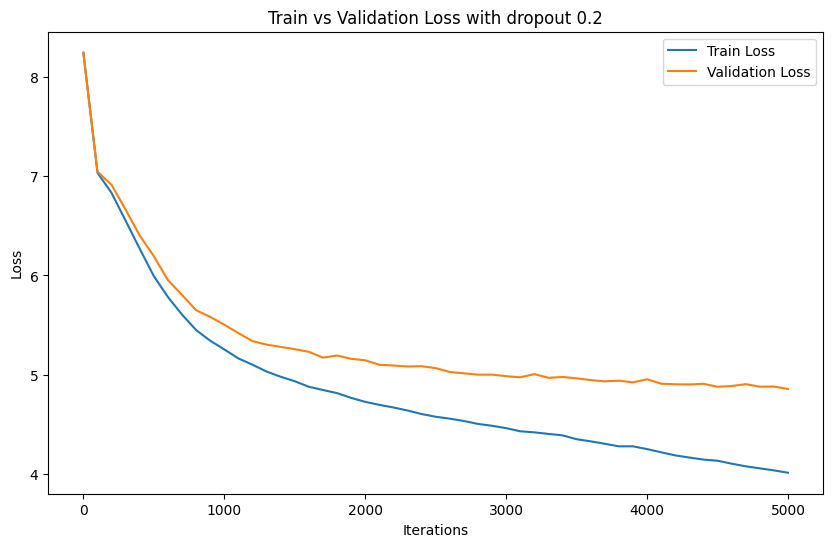

 head,
Condemns! Of these city obears to his nees,
You Northumberlands, and your patiate fights.

ELBoth:
Holy V bad, I would be patience; bear my husband:
And I took in comething neared these coron thy sons.

WARWICK:
And never, and what to order friends with this dead.
Give me the four's face.

YORK:
'Twould be not be es good lord nor parent;
With know not, like companother conds
yourselfse 'er the gue officers the fortune's please!
O my royal had not be take: I se'er they have takest, rop sirst, tend,
onETERt's plaintaldial herly
An yon a bred blood
May not so much Tybalt locult and their was done,
And shall be God-tedann'd the dishonoursald,
By my kingdom's trook'd to my made: yet tell thee n along a thousand eyes urse
buke too ented ovent'd me forth
Is deeds with his father should soarestate hate upon't.

STLooks do?MARCIUS:
s there mercy?

BALEPETER:
That seon me, mistrates put how seen.

WARWICK:

GLOUCESTER:
Romeo, we cannot befor thee.

Third Citizens:
R Broives often said I l

step 3000: train loss 4.5233, val loss 5.0096
step 3100: train loss 4.5124, val loss 5.0082
step 3200: train loss 4.4862, val loss 5.0046
step 3300: train loss 4.4597, val loss 4.9647
step 3400: train loss 4.4494, val loss 4.9810
step 3500: train loss 4.4259, val loss 4.9879
step 3600: train loss 4.4101, val loss 4.9615
step 3700: train loss 4.3853, val loss 4.9714
step 3800: train loss 4.3639, val loss 4.9852
step 3900: train loss 4.3521, val loss 4.9697
step 4000: train loss 4.3276, val loss 4.9402
step 4100: train loss 4.3116, val loss 4.9350
step 4200: train loss 4.2872, val loss 4.9507
step 4300: train loss 4.2816, val loss 4.9227
step 4400: train loss 4.2410, val loss 4.9519
step 4500: train loss 4.2373, val loss 4.9317
step 4600: train loss 4.2159, val loss 4.9131
step 4700: train loss 4.1886, val loss 4.9205
step 4800: train loss 4.1736, val loss 4.9333
step 4900: train loss 4.1589, val loss 4.9026
step 4999: train loss 4.1546, val loss 4.9100
Average iteration time: 1.9615 sec

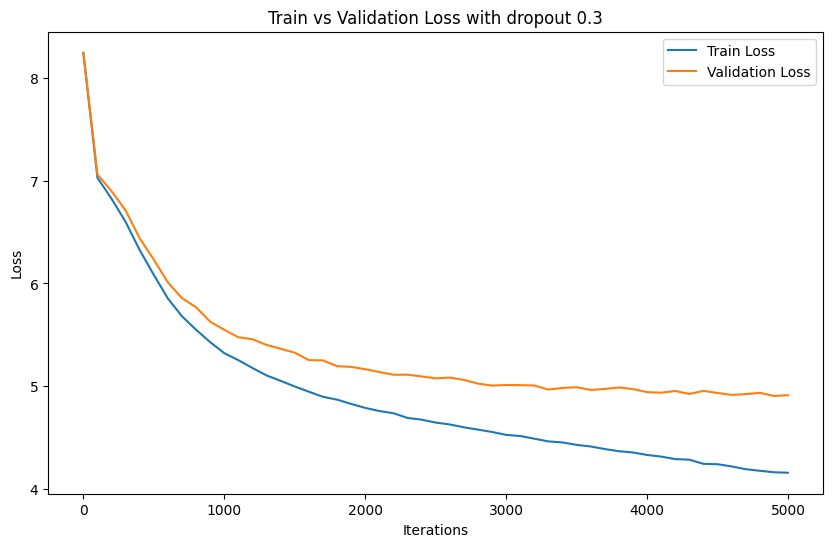

 tion to beat se--to here's a pleadarks himself king!

BRUTUS:
My wife, give me kiss the power.

Be, my lieits your grace's Coriolanus!
A dmock the msecond meandeet, and kill, so much grip,
To rob it o'er often sad than e'er do with you were lt g keep it perfor us.

SICINIUS:
Why, I'll bear!
On; I must not pew me in say.

Clown:
He bear this is banish him to-night;
But afkind, so good we have more than being.

KING LEWIS Too rather; and there I were
Rest for the purpose with a manner-like, provoice my grace.

EERBY:
Halready is so shed looks be all:
Good my lord; thou art banish'd eny doubt.
A vesseless us.

First Servant:
This cratch the poor,
Shall I, that for brit with me to ouroo cience.
Like this suffer alone?
All-ute.

BRUTUS:
For God's sawantuon my ty, who lling boot love thee dead.
And thenvise, that there was of all the vests?

Nurse:
Yet our God's namezed mistres strifought ness
Of these f army, beggares, and his heart: 'tis rather
That late themest, no better, too as the pow

In [29]:
#dropout tuning

def test_dropout(learning_rates, hyperparameters_space, train_data, val_data):
    for i in dropouts:

        config = hyperparameters_space.copy()
        config['dropout'] = i


        print(f"Testing dropout: {i}")


        model, train_losses, val_losses = train_model(config, train_data, val_data)

        train_steps, train_losses = zip(*train_losses)
        val_steps, val_losses = zip(*val_losses)

        plt.figure(figsize=(10, 6))
        plt.plot(train_steps, train_losses, label='Train Loss')
        plt.plot(val_steps, val_losses, label='Validation Loss')
        plt.xlabel('Iterations')
        plt.ylabel('Loss')
        plt.title(f'Train vs Validation Loss with dropout {i}')
        plt.legend()
        plt.show()

        context = torch.zeros((1, 1), dtype=torch.long, device=device)
        generated_text = bpe_re.decode(model.generate(context, max_new_tokens=2000, block_size=config['block_size'])[0].tolist())
        #result = spelling_check(generated_text)

        print(generated_text)
        print("="*50)



dropouts = [0.0,0.2,0.3]
hyperparameters_space = {'n_embd': 488, 'n_head': 8, 'n_layer': 10, 'block_size': 32, 'batch_size': 16, 'learning_rate':1e-4,'vocab_size':3257}
test_dropout(dropouts, hyperparameters_space, train_data_bpere, val_data_bpere)
